In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns
import pandas as pd

sns.set_style("ticks")

def plot_data_2(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 8 # marker size
    fs_1 = 7
    fs_2 = 7
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 1.8
    fig.set_size_inches(scale*1.6,scale*1.6)

    ax.xaxis.set_tick_params(length=3)
    ax.yaxis.set_tick_params(length=3)
    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)

# Experimental parameters 

In [2]:
# Dielectric materials can be modelled using Cauchy model
def Cauchy_n (l, A, B, C=0):
    l_um = l/1000
    
    if type(l) == 'numpy.ndarray':
        return [A + B/l**2 + C/l for l in l_um]
    else:
        return A + B/l_um**2 + C/l_um**4
    
# Optical proerties of glass (measured using ellipsometer)
A_glass = 1.5046
B_glass = 0.00420

# Optical properties of oil (measured using ellipsometer)
A_si = 1.491665          
B_si = 0.006025112

n_silicone_488 = Cauchy_n(488, A_si, B_si)
n_silicone_561 = Cauchy_n(561, A_si, B_si)
print(n_silicone_488, n_silicone_561)

#optical properties of water
A_water = 1.321994
B_water = 0.005341558
n_water_488 = Cauchy_n(488, A_water, B_water)
n_water_561 = Cauchy_n(561, A_water, B_water)
print (n_water_488, n_water_561)

# thickness of cellulose layer measured using AFM
h_dry = 68 # nm
h_wet = 126 # nm
phi = 68./126 # cellulose content

# refractive index of cellulose
# https://www.filmetrics.com/refractive-index-database/Cellulose
n_cellulose_488 = 1.476
n_cellulose_561 = 1.472
n_wet_488 = phi*n_cellulose_488 + (1-phi)*n_water_488
n_wet_561 = phi*n_cellulose_561 + (1-phi)*n_water_561
print (n_wet_488, n_wet_561)


1.5169652889008332 1.5108092960590491
1.344423949946251 1.3389663596455272
1.4154332468006552 1.4107622925352428


# Fresnel theory

In [3]:
def I_func(l, h_water, h_wet): # h in nm
    
    n_water = Cauchy_n(l, A_water, B_water)
    n_glass = Cauchy_n(l, A_glass, B_glass)
    
    if l==488:
        n_wet = n_wet_488
    elif l==561:
        n_wet = n_wet_561
        
    n_oil = Cauchy_n(l, A_si, B_si)
    
    I1 = (n_wet-n_glass)**2/(n_wet+n_glass)**2
    I2 = (n_wet-n_water)**2/(n_wet+n_water)**2
    I3 = (n_wet-n_oil)**2/(n_wet+n_oil)**2
    
    phi_1 = 4*np.pi/l*(n_wet*h_wet)
    phi_2 = 4*np.pi/l*(n_wet*h_wet + n_water*h_water) + np.pi
    
    h_arr = np.linspace(0,1000,1000)
    phi_3 = 4*np.pi/l*(n_wet*h_wet + n_water*h_arr) + np.pi
    
        
    I = (I1+I2+I3 + 2*np.sqrt(I1*I2)*np.cos(phi_1) +   
        2*np.sqrt(I1*I3)*np.cos(phi_2) + 
        2*np.sqrt(I2*I3)*np.cos(phi_1-phi_2))
    
    I_ref = (I1+I2+I3 + 2*np.sqrt(I1*I2)*np.cos(phi_1) +   
        2*np.sqrt(I1*I3)*np.cos(phi_3) + 
        2*np.sqrt(I2*I3)*np.cos(phi_1-phi_3))
    
    I_min = np.amin(I_ref)
    I_max = np.amax(I_ref)
    I_norm = (I-I_min)/(I_max-I_min)
    return I_norm

# Data

Normalized intensity for w = 488 nm

(0.0, 1.05)

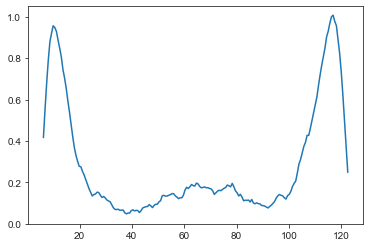

In [4]:
df = pd.read_csv('regenerate_cellulose_488nm.csv')
x_488 = df.x[10:-10]
# I_488_norm = df["I_norm"]
I_min = 170
I_488_norm = (df["I"][10:-10]-I_min)/(df["I_max"][10:-10]-I_min)
I_488_norm = (df["I"][10:-10]-I_min)/(3300-I_min)

# I_488_norm = df["I"]/3323

plt.plot(x_488, I_488_norm)
plt.ylim([0,1.05])

Normalized intensity for w = 561 nm

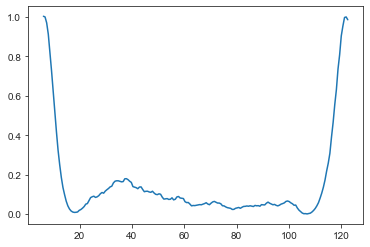

In [5]:
df = pd.read_csv('regenerate_cellulose_561nm.csv')
x_561 = df.x[10:-10]
I_min = 130

I_561_norm = (df["I"][10:-10]-I_min)/(4050-I_min)
I_561_norm = (df["I"][10:-10]-I_min)/(df["I_max"][10:-10]-I_min)

plt.plot(x_561, I_561_norm)

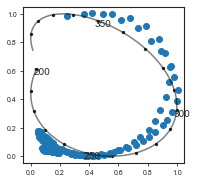

In [6]:
fig_4, ax_4 = plt.subplots()
fig_4.set_size_inches([5,5])

h_start, h_end = 200, 400

h_arr_ref = np.linspace(h_start,h_end,1000)
I_arr_488 = I_func(488, h_arr_ref, h_wet)
I_arr_561 = I_func(561., h_arr_ref, h_wet)
ax_4.plot(I_arr_488, I_arr_561, '-k', alpha=0.5)

# add marker
h_marker = np.arange(h_start,h_end,10)

# plot labels 
for h_m in h_marker:
    x = I_func(488, h_m, h_wet)
    y = I_func(561, h_m, h_wet)
    
    ax_4.scatter(x, y, color="k",edgecolor = "k", 
                 marker='o', s=5, alpha=0.8)
    
    if (h_m%50==0):
        ax_4.text(x-0.02, y-0.04, h_m, fontsize=10)


ax_4.scatter(I_488_norm, I_561_norm)

ax_4.set_xlim([-0.05,1.05])
ax_4.set_ylim([-0.05,1.05])

plot_data_2(fig_4, ax_4)

# Fit with height

In [7]:
def calculate_height_ind(I_1, I_2, I_ref_1, I_ref_2):

    err_arr = np.sqrt((I_1-I_ref_1)**2 + (I_2-I_ref_2)**2)
    i_min, err_min = np.argmin(err_arr), np.amin(err_arr)
    
    return h_arr_ref[i_min]


In [8]:
h_start, h_end = 200, 400

h_arr_ref = np.linspace(h_start,h_end,1000)
I_arr_488 = I_func(488, h_arr_ref, h_wet)
I_arr_561 = I_func(561., h_arr_ref, h_wet)

h_arr = np.array([])
for i in range(len(I_488_norm)):
    I_1 = I_488_norm.values[i]
    I_2 = I_561_norm.values[i]
    
    I_ref_1 = I_arr_488
    I_ref_2 = I_arr_561
    
    h_arr = np.append(h_arr, calculate_height_ind(I_1, I_2, I_ref_1, I_ref_2))

(0.0, 340.0)

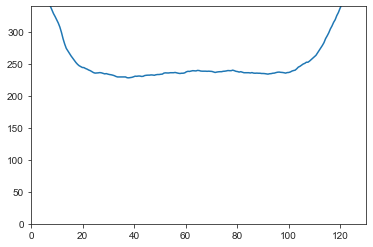

In [9]:
plt.plot(x_488, h_arr)
plt.xlim([0, 130])
plt.ylim([0, 340])

# Plot profiles

In [10]:
def plot_data(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 8 # marker size
    fs_1 = 7
    fs_2 = 7
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 1.0
    fig.set_size_inches(scale*2.4,scale*1.2)

    ax.xaxis.set_tick_params(length=3)
    ax.yaxis.set_tick_params(length=3)
    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)
    
    
def plot_data_2(fig, ax):
    ls_1 = 1.0
    ls_2 = 1.0
    ls_3 = 0.8

    ms = 8 # marker size
    fs_1 = 7
    fs_2 = 7
    
    ax.tick_params(axis='x', labelsize=fs_1)
    ax.tick_params(axis='y', labelsize=fs_1)

    scale = 1.0
    fig.set_size_inches(scale*4.1,scale*2.0)

    ax.xaxis.set_tick_params(length=3)
    ax.yaxis.set_tick_params(length=3)
    
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.1)
    
ls_1 = 1.0
ls_2 = 1.0
ls_3 = 0.8

ms = 8 # marker size
fs_1 = 7
fs_2 = 7

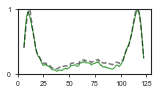

In [11]:
fig_b, ax_b = plt.subplots()
ax_b.plot(x_488, I_488_norm, '-g', linewidth = ls_1, alpha=0.8)

ax_b.set_xlim([0,130])
ax_b.set_ylim([0,1.0])
ax_b.set_yticks([0,1])
plot_data(fig_b, ax_b)

I1 = I_func(488., h_arr, h_wet)
ax_b.plot(x_488, I1, '--k', alpha=0.5)
fig_b.savefig('I_488nm.pdf')

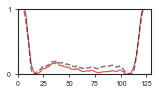

In [12]:
fig_b, ax_b = plt.subplots()
ax_b.plot(x_561, I_561_norm, '-r', linewidth = ls_1, alpha=0.8)

ax_b.set_xlim([0,130])
ax_b.set_ylim([0,1.0])
ax_b.set_yticks([0,1])
plot_data(fig_b, ax_b)

I1 = I_func(561., h_arr, h_wet)
ax_b.plot(x_561, I1, '--k', alpha=0.5)
fig_b.savefig('I_561nm.pdf')

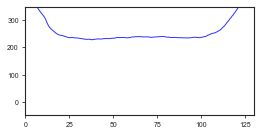

In [13]:
fig, ax = plt.subplots()
ax.plot(x_488, h_arr, '-b', linewidth = ls_1, alpha=0.8)
ax.set_xlim([0, 130])
ax.set_ylim([-50, 350])
ax.set_yticks([0, 100, 200, 300])
ax.set_xticks([0, 25, 50, 75, 100, 125])

plot_data_2(fig, ax)
fig.savefig('film_thickness.pdf')